In [1]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import datetime
from IPython import display
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [3]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
# TODO
test_images = images[10000:12000]

# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images to train on


In [4]:
# create training and test tf.datasets
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
test_ds = tf.data.Dataset.from_tensor_slices(test_images)

<TakeDataset shapes: (784,), types: tf.uint8>
<MapDataset shapes: (28, 28, 1), types: tf.float32>


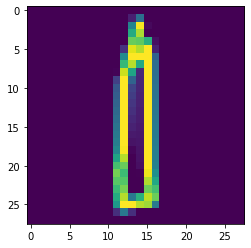

In [5]:
# print original and wanted shape and show image 
temp = test_ds.take(1)
print(temp)
temp = temp.map(lambda image: (tf.cast(tf.reshape(image, [28,28,1]), tf.float32)))
print(temp)
for elem in temp:
  plt.imshow(elem[ :, :, 0])

In [6]:
def prepare(ds):   
  # Prepare data for model  
  ds = ds.map(lambda img: (tf.cast(img, tf.float32)))
  ds = ds.map(lambda img:(tf.reshape(img, [28,28,1])))
  ds = ds.map(lambda img: ((img/128.)-1.))  
  # cache 
  ds = ds.cache()
  # shuffle, batch, prefetch our dataset
  ds = ds.shuffle(5000)
  ds = ds.batch(256)
  ds = ds.prefetch(1024)
  return ds

In [7]:
train_ds = prepare(train_ds)
test_ds = prepare(test_ds)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose, MaxPool2D, Dropout, BatchNormalization, LeakyReLU

In [9]:
class Discriminator(Model):

  def __init__(self):
    super(Discriminator, self).__init__()

    # list of loss and accuracy for training 
    self.metrics_list = [
      tf.keras.metrics.Mean(name="disc_loss"),
      tf.keras.metrics.BinaryAccuracy(name="disc_acc") ]

    self.discriminator = [
      Conv2D(32, (3,3), strides=(2, 2), activation='relu', padding='same', input_shape=[28, 28, 1]),
      BatchNormalization(),
      Dropout(0.3),

      Conv2D(64, (3,3), activation='relu', strides=(2, 2), padding='same'),
      BatchNormalization(),
      Dropout(0.3),

      Conv2D(32, (3,3), activation='relu', strides=(2, 2), padding='same'),
      BatchNormalization(),
      Dropout(0.3),
      
      Flatten(),
      Dense(1, activation='sigmoid')
      ]
  
  @tf.function
  def call(self, x, training=True):

    for layer in self.discriminator:
      x = layer(x, training=training)
    return x

  # function to reset the metric values
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()

In [10]:
class Generator(Model):

  def __init__(self):
    super(Generator, self).__init__()

    # list of loss and accuracy for training 
    self.metrics_list = [
      tf.keras.metrics.Mean(name="gen_loss"),
      tf.keras.metrics.BinaryAccuracy(name="gen_acc") ]

    self.generator = [
      Dense(7*7*256, use_bias=False, input_shape=(100,)),
      BatchNormalization(),
      LeakyReLU(),

      Reshape((7,7,256)),

      Conv2DTranspose(64, (2,2), strides=(1,1), padding='same'),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(128, (2,2), strides=(2,2), padding='same'),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(128, (2,2), strides=(1,1), padding='same'),
      BatchNormalization(),
      LeakyReLU(),

      Conv2DTranspose(64, (2,2), strides=(1,1), padding='same'),
      BatchNormalization(),
      LeakyReLU(),
      
      Conv2DTranspose(filters= 1, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
      ]

  @tf.function
  def call(self, x, training=True):

    for layer in self.generator:
      x = layer(x, training=training)
    return x

  # function to reset the metric values
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()

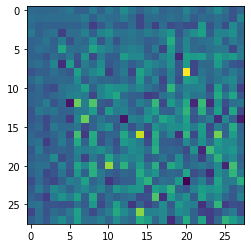

In [11]:
# test generator
sample_generator = Generator()

generated_image = sample_generator(tf.random.normal([1, 100]), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [12]:
#test discriminator on generated image
test_discriminator = Discriminator()
result = test_discriminator(generated_image)
print(result)

tf.Tensor([[0.8509281]], shape=(1, 1), dtype=float32)


In [13]:
def generate_image(model, epoch, test_input):
  # `training` set to False.
  # This is so all layers run in inference mode (batchnorm)

  # get image from generator
  predictions = model(test_input, training=False)

  # plot image
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.show()

In [14]:
def discriminator_loss(real_output, fake_output, loss_func):
  # compute loss for discriminator
  real_loss = loss_func(tf.ones_like(real_output), real_output)
  fake_loss = loss_func(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output, loss_func):
  # compute loss for generator
  return loss_func(tf.ones_like(fake_output), fake_output)

In [15]:
@tf.function
def train_step(images, loss_func):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise)

      real_output = discriminator(images)
      fake_output = discriminator(generated_images)

      gen_loss = generator_loss(fake_output, loss_func)
      disc_loss = discriminator_loss(real_output, fake_output, loss_func)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # update loss metric
    discriminator.metrics[0].update_state(disc_loss)
    generator.metrics[0].update_state(gen_loss)
    
    # for all metrics except loss, update states (accuracy etc.)
    for metric in discriminator.metrics[1:]:
      metric.update_state(tf.ones_like(real_output), real_output)
      metric.update_state(tf.zeros_like(fake_output), fake_output)
    
    for metric in generator.metrics[1:]:
      metric.update_state(tf.ones_like(fake_output), fake_output)

    # Return a dictionary mapping metric names to current value
    disc_metrics = {m.name: m.result() for m in discriminator.metrics}
    gen_metrics = {m.name: m.result() for m in generator.metrics}
    return  gen_metrics , disc_metrics

def test_step(images, loss_func):
  generated_images = generator(noise, training=False)
  
  real_output = discriminator(images, training=False)
  fake_output = discriminator(generated_images, training=False)

  gen_loss = generator_loss(fake_output, loss_func)

  disc_loss = discriminator_loss(real_output, fake_output, loss_func)

  # update loss metric
  discriminator.metrics[0].update_state(disc_loss)
  generator.metrics[0].update_state(gen_loss)
  
  # for all metrics except loss, update states (accuracy etc.)
  for metric in discriminator.metrics[1:]:
    metric.update_state(tf.ones_like(real_output), real_output)
    metric.update_state(tf.zeros_like(fake_output), fake_output)
  
  for metric in generator.metrics[1:]:
    metric.update_state(tf.ones_like(fake_output), fake_output)

  # Return a dictionary mapping metric names to current value
  disc_metrics = {m.name: m.result() for m in discriminator.metrics}
  gen_metrics = {m.name: m.result() for m in generator.metrics}

  return  gen_metrics , disc_metrics

In [16]:
tf.keras.backend.clear_session()
def training(train_data, test_data, loss_function, epochs):
  # train models
  for epoch in range(epochs):
    print()
    print(f"Epoch {epoch}:")
    
    for data in train_data:
        gen_metrics, disc_metrics = train_step(data, loss_function)
                                    
    print("Discriminator")
    print([f"{key}: {value}" for (key, value) in zip(list(disc_metrics.keys()), list(disc_metrics.values()))])
    print("Generator")
    print([f"{key}: {value}" for (key, value) in zip(list(gen_metrics.keys()), list(gen_metrics.values()))])
    
    # logging the validation metrics to the log file with tensorboard
    with train_summary_writer.as_default():
        for metric in generator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        for metric in discriminator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
    
    # reset metrics in models
    discriminator.reset_metrics()
    generator.reset_metrics()
    
    # test models
    for data in test_data:
        gen_metrics, disc_metrics = test_step(data, loss_function)
                                
    print("Discriminator")
    print([f"test_{key}: {value}" for (key, value) in zip(list(disc_metrics.keys()), list(disc_metrics.values()))])
    print("Generator")
    print([f"test_{key}: {value}" for (key, value) in zip(list(gen_metrics.keys()), list(gen_metrics.values()))])

    # show generated images                                              
    generate_image(generator, epoch + 1, seed)
    
    # logging the validation metrics to the log file with tensorboard
    with val_summary_writer.as_default():
        for metric in generator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        for metric in discriminator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
    
    # reset metrics in models
    discriminator.reset_metrics()
    generator.reset_metrics()

In [17]:
# initialize models 
generator = Generator()
discriminator = Discriminator()

# hyperparameters
BATCH_SIZE = 256

EPOCHS = 50

LOSS_FUNC = tf.keras.losses.BinaryCrossentropy()

gen_optimizer = tf.keras.optimizers.Adam(0.001)
disc_optimizer = tf.keras.optimizers.Adam(0.001)

# additional parameters for noise creation
noise_dim = 100
num_examples_to_generate = 4

noise = tf.random.normal([1, 100])
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
# Define saving location for log
hyperparameter_string= f"Trial:02_BATCH:{BATCH_SIZE}_EPOCH:{EPOCHS}_Adam"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{hyperparameter_string}/{current_time}/train"
val_log_path = f"logs/{hyperparameter_string}/{current_time}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path)


Epoch 0:
Discriminator
['disc_loss: 1.4126942157745361', 'disc_acc: 0.657608687877655']
Generator
['gen_loss: 0.8038431406021118', 'gen_acc: 0.62158203125']
Discriminator
['test_disc_loss: 1.2732230424880981', 'test_disc_acc: 0.01842629536986351']
Generator
['test_gen_loss: 1.0479168891906738', 'test_gen_acc: 0.0']


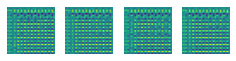


Epoch 1:
Discriminator
['disc_loss: 0.553519606590271', 'disc_acc: 0.8696146011352539']
Generator
['gen_loss: 1.9304364919662476', 'gen_acc: 0.24814453721046448']
Discriminator
['test_disc_loss: 1.830906629562378', 'test_disc_acc: 0.0039840638637542725']
Generator
['test_gen_loss: 2.1763970851898193', 'test_gen_acc: 0.0']


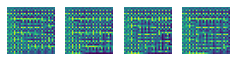


Epoch 2:
Discriminator
['disc_loss: 0.19485421478748322', 'disc_acc: 0.9702075123786926']
Generator
['gen_loss: 3.2019500732421875', 'gen_acc: 0.04697265475988388']
Discriminator
['test_disc_loss: 1.8945776224136353', 'test_disc_acc: 0.0039840638637542725']
Generator
['test_gen_loss: 3.242738723754883', 'test_gen_acc: 0.0']


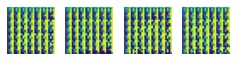


Epoch 3:
Discriminator
['disc_loss: 0.37745168805122375', 'disc_acc: 0.927420973777771']
Generator
['gen_loss: 3.305990219116211', 'gen_acc: 0.12607422471046448']
Discriminator
['test_disc_loss: 3.2293624877929688', 'test_disc_acc: 0.0039840638637542725']
Generator
['test_gen_loss: 8.442510604858398', 'test_gen_acc: 0.0']


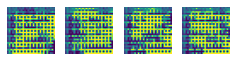


Epoch 4:
Discriminator
['disc_loss: 0.2725720703601837', 'disc_acc: 0.9554347991943359']
Generator
['gen_loss: 3.2804312705993652', 'gen_acc: 0.05820312350988388']
Discriminator
['test_disc_loss: 3.9519131183624268', 'test_disc_acc: 0.0039840638637542725']
Generator
['test_gen_loss: 2.907863140106201', 'test_gen_acc: 0.0']


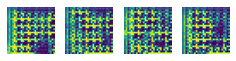


Epoch 5:
Discriminator
['disc_loss: 0.16484434902668', 'disc_acc: 0.9758399128913879']
Generator
['gen_loss: 4.474881172180176', 'gen_acc: 0.0322265625']
Discriminator
['test_disc_loss: 4.270965099334717', 'test_disc_acc: 0.007968127727508545']
Generator
['test_gen_loss: 2.3680837154388428', 'test_gen_acc: 0.0']


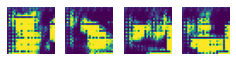


Epoch 6:
Discriminator
['disc_loss: 0.3021175265312195', 'disc_acc: 0.9484189748764038']
Generator
['gen_loss: 3.8601508140563965', 'gen_acc: 0.05097656324505806']
Discriminator
['test_disc_loss: 3.4981417655944824', 'test_disc_acc: 0.019422311335802078']
Generator
['test_gen_loss: 7.778450012207031', 'test_gen_acc: 0.0']


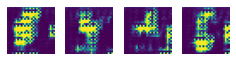


Epoch 7:
Discriminator
['disc_loss: 0.2932888865470886', 'disc_acc: 0.9488142132759094']
Generator
['gen_loss: 3.7458291053771973', 'gen_acc: 0.04833984375']
Discriminator
['test_disc_loss: 4.277790069580078', 'test_disc_acc: 0.008964143693447113']
Generator
['test_gen_loss: 7.431891441345215', 'test_gen_acc: 0.0']


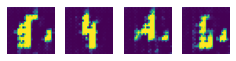


Epoch 8:
Discriminator
['disc_loss: 0.37807101011276245', 'disc_acc: 0.9280138611793518']
Generator
['gen_loss: 3.753084182739258', 'gen_acc: 0.06728515774011612']
Discriminator
['test_disc_loss: 0.7791171669960022', 'test_disc_acc: 0.6284860372543335']
Generator
['test_gen_loss: 6.054751396179199', 'test_gen_acc: 0.0']


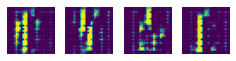


Epoch 9:
Discriminator
['disc_loss: 0.2271367758512497', 'disc_acc: 0.9593379497528076']
Generator
['gen_loss: 4.363739967346191', 'gen_acc: 0.03642578050494194']
Discriminator
['test_disc_loss: 1.4647794961929321', 'test_disc_acc: 0.2878485918045044']
Generator
['test_gen_loss: 5.514914035797119', 'test_gen_acc: 0.0']


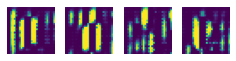


Epoch 10:
Discriminator
['disc_loss: 0.22888782620429993', 'disc_acc: 0.9630434513092041']
Generator
['gen_loss: 4.128592491149902', 'gen_acc: 0.03525390475988388']
Discriminator
['test_disc_loss: 0.7473686337471008', 'test_disc_acc: 0.6339641213417053']
Generator
['test_gen_loss: 3.025247097015381', 'test_gen_acc: 0.0']


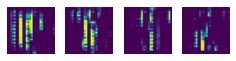


Epoch 11:
Discriminator
['disc_loss: 0.32370513677597046', 'disc_acc: 0.9402173757553101']
Generator
['gen_loss: 3.852928638458252', 'gen_acc: 0.06005859375']
Discriminator
['test_disc_loss: 0.6388772130012512', 'test_disc_acc: 0.7320716977119446']
Generator
['test_gen_loss: 3.2080705165863037', 'test_gen_acc: 0.0']


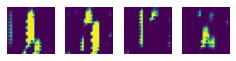


Epoch 12:
Discriminator
['disc_loss: 0.23446419835090637', 'disc_acc: 0.9611660242080688']
Generator
['gen_loss: 3.9047627449035645', 'gen_acc: 0.03623046725988388']
Discriminator
['test_disc_loss: 1.9265599250793457', 'test_disc_acc: 0.2345617562532425']
Generator
['test_gen_loss: 6.325242042541504', 'test_gen_acc: 0.0']


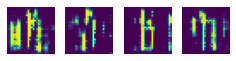


Epoch 13:
Discriminator
['disc_loss: 0.21474480628967285', 'disc_acc: 0.9632905125617981']
Generator
['gen_loss: 4.203124046325684', 'gen_acc: 0.03427734225988388']
Discriminator
['test_disc_loss: 2.953681707382202', 'test_disc_acc: 0.09013944119215012']
Generator
['test_gen_loss: 7.307716369628906', 'test_gen_acc: 0.0']


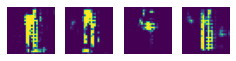


Epoch 14:
Discriminator
['disc_loss: 0.21391363441944122', 'disc_acc: 0.9651185870170593']
Generator
['gen_loss: 4.341317176818848', 'gen_acc: 0.02851562574505806']
Discriminator
['test_disc_loss: 2.3792941570281982', 'test_disc_acc: 0.1379482001066208']
Generator
['test_gen_loss: 5.647464275360107', 'test_gen_acc: 0.0']


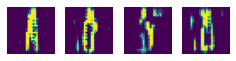


Epoch 15:
Discriminator
['disc_loss: 0.24787962436676025', 'disc_acc: 0.9540513753890991']
Generator
['gen_loss: 4.4618706703186035', 'gen_acc: 0.04521484300494194']
Discriminator
['test_disc_loss: 2.341805934906006', 'test_disc_acc: 0.08466135710477829']
Generator
['test_gen_loss: 8.549683570861816', 'test_gen_acc: 0.0']


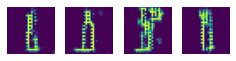


Epoch 16:
Discriminator
['disc_loss: 0.21315617859363556', 'disc_acc: 0.9594367742538452']
Generator
['gen_loss: 4.961668491363525', 'gen_acc: 0.03818359225988388']
Discriminator
['test_disc_loss: 5.845574378967285', 'test_disc_acc: 0.009960159659385681']
Generator
['test_gen_loss: 7.260563850402832', 'test_gen_acc: 0.0']


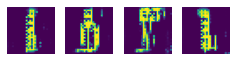


Epoch 17:
Discriminator
['disc_loss: 0.16818676888942719', 'disc_acc: 0.9694169759750366']
Generator
['gen_loss: 5.039627552032471', 'gen_acc: 0.02841796912252903']
Discriminator
['test_disc_loss: 7.4444499015808105', 'test_disc_acc: 0.020418327301740646']
Generator
['test_gen_loss: 12.241456031799316', 'test_gen_acc: 0.0']


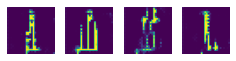


Epoch 18:
Discriminator
['disc_loss: 0.2125486433506012', 'disc_acc: 0.960573136806488']
Generator
['gen_loss: 5.18405818939209', 'gen_acc: 0.03662109375']
Discriminator
['test_disc_loss: 0.3823643922805786', 'test_disc_acc: 0.9795816540718079']
Generator
['test_gen_loss: 1.385143518447876', 'test_gen_acc: 0.0']


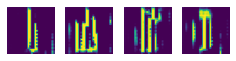


Epoch 19:
Discriminator
['disc_loss: 0.16631385684013367', 'disc_acc: 0.9707015752792358']
Generator
['gen_loss: 5.4496588706970215', 'gen_acc: 0.03339843824505806']
Discriminator
['test_disc_loss: 1.2722057104110718', 'test_disc_acc: 0.9880478382110596']
Generator
['test_gen_loss: 0.3589347004890442', 'test_gen_acc: 1.0']


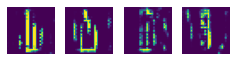


Epoch 20:
Discriminator
['disc_loss: 0.08713140338659286', 'disc_acc: 0.9864624738693237']
Generator
['gen_loss: 6.413701057434082', 'gen_acc: 0.013378906063735485']
Discriminator
['test_disc_loss: 0.5384318828582764', 'test_disc_acc: 0.7714143395423889']
Generator
['test_gen_loss: 3.0721006393432617', 'test_gen_acc: 0.0']


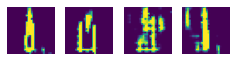


Epoch 21:
Discriminator
['disc_loss: 0.08839099109172821', 'disc_acc: 0.9914525747299194']
Generator
['gen_loss: 6.511266231536865', 'gen_acc: 0.008984374813735485']
Discriminator
['test_disc_loss: 0.04526267945766449', 'test_disc_acc: 0.9985059499740601']
Generator
['test_gen_loss: 3.305426597595215', 'test_gen_acc: 0.0']


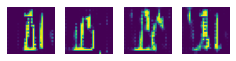


Epoch 22:
Discriminator
['disc_loss: 0.14283691346645355', 'disc_acc: 0.9757905006408691']
Generator
['gen_loss: 6.147749900817871', 'gen_acc: 0.03037109412252903']
Discriminator
['test_disc_loss: 2.0018410682678223', 'test_disc_acc: 0.17380477488040924']
Generator
['test_gen_loss: 5.403701305389404', 'test_gen_acc: 0.0']


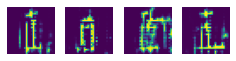


Epoch 23:
Discriminator
['disc_loss: 0.1950443685054779', 'disc_acc: 0.9652668237686157']
Generator
['gen_loss: 4.787522315979004', 'gen_acc: 0.02949218824505806']
Discriminator
['test_disc_loss: 1.8595163822174072', 'test_disc_acc: 0.21713148057460785']
Generator
['test_gen_loss: 4.862757205963135', 'test_gen_acc: 0.0']


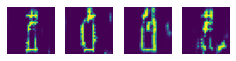


Epoch 24:
Discriminator
['disc_loss: 0.23645897209644318', 'disc_acc: 0.955978274345398']
Generator
['gen_loss: 4.975385665893555', 'gen_acc: 0.04042968899011612']
Discriminator
['test_disc_loss: 5.32848596572876', 'test_disc_acc: 0.0657370537519455']
Generator
['test_gen_loss: 8.706950187683105', 'test_gen_acc: 0.0']


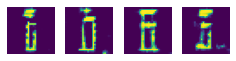


Epoch 25:
Discriminator
['disc_loss: 0.15122486650943756', 'disc_acc: 0.9740118384361267']
Generator
['gen_loss: 5.647532939910889', 'gen_acc: 0.02187499962747097']
Discriminator
['test_disc_loss: 2.506112575531006', 'test_disc_acc: 0.9960159659385681']
Generator
['test_gen_loss: 0.0853179469704628', 'test_gen_acc: 1.0']


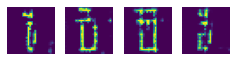


Epoch 26:
Discriminator
['disc_loss: 0.1644386202096939', 'disc_acc: 0.9697628617286682']
Generator
['gen_loss: 5.9300737380981445', 'gen_acc: 0.02685546875']
Discriminator
['test_disc_loss: 2.085747480392456', 'test_disc_acc: 0.4003984034061432']
Generator
['test_gen_loss: 2.542226791381836', 'test_gen_acc: 0.0']


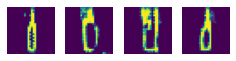


Epoch 27:
Discriminator
['disc_loss: 0.22054477035999298', 'disc_acc: 0.9572628736495972']
Generator
['gen_loss: 5.899145126342773', 'gen_acc: 0.03886718675494194']
Discriminator
['test_disc_loss: 3.7706310749053955', 'test_disc_acc: 0.26095616817474365']
Generator
['test_gen_loss: 6.296173095703125', 'test_gen_acc: 0.0']


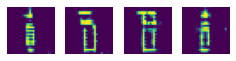


Epoch 28:
Discriminator
['disc_loss: 0.13196878135204315', 'disc_acc: 0.9762351512908936']
Generator
['gen_loss: 5.934396266937256', 'gen_acc: 0.02304687537252903']
Discriminator
['test_disc_loss: 6.735785484313965', 'test_disc_acc: 0.037350598722696304']
Generator
['test_gen_loss: 9.274274826049805', 'test_gen_acc: 0.0']


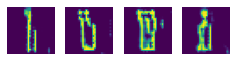


Epoch 29:
Discriminator
['disc_loss: 0.09703940898180008', 'disc_acc: 0.9837944507598877']
Generator
['gen_loss: 6.500845432281494', 'gen_acc: 0.01552734337747097']
Discriminator
['test_disc_loss: 4.107800006866455', 'test_disc_acc: 0.1528884470462799']
Generator
['test_gen_loss: 7.74216365814209', 'test_gen_acc: 0.0']


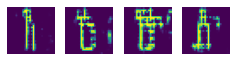


Epoch 30:
Discriminator
['disc_loss: 0.07061106711626053', 'disc_acc: 0.9881423115730286']
Generator
['gen_loss: 7.072835445404053', 'gen_acc: 0.01210937462747097']
Discriminator
['test_disc_loss: 7.075812339782715', 'test_disc_acc: 0.05527888610959053']
Generator
['test_gen_loss: 13.061660766601562', 'test_gen_acc: 0.0']


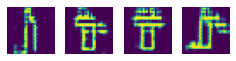


Epoch 31:
Discriminator
['disc_loss: 0.053791262209415436', 'disc_acc: 0.9917489886283875']
Generator
['gen_loss: 7.606183052062988', 'gen_acc: 0.006054687313735485']
Discriminator
['test_disc_loss: 0.6275469064712524', 'test_disc_acc: 0.6897410154342651']
Generator
['test_gen_loss: 2.712533473968506', 'test_gen_acc: 0.0']


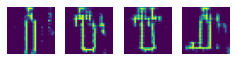


Epoch 32:
Discriminator
['disc_loss: 0.1554311215877533', 'disc_acc: 0.9722825884819031']
Generator
['gen_loss: 6.015789985656738', 'gen_acc: 0.02685546875']
Discriminator
['test_disc_loss: 2.6947309970855713', 'test_disc_acc: 0.9940239191055298']
Generator
['test_gen_loss: 0.07029026746749878', 'test_gen_acc: 1.0']


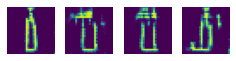


Epoch 33:
Discriminator
['disc_loss: 0.1949799507856369', 'disc_acc: 0.9624999761581421']
Generator
['gen_loss: 5.731902122497559', 'gen_acc: 0.03750000149011612']
Discriminator
['test_disc_loss: 0.6393723487854004', 'test_disc_acc: 0.8232071995735168']
Generator
['test_gen_loss: 1.5153321027755737', 'test_gen_acc: 0.0']


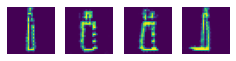


Epoch 34:
Discriminator
['disc_loss: 0.1332017481327057', 'disc_acc: 0.9778162240982056']
Generator
['gen_loss: 5.659377098083496', 'gen_acc: 0.01875000074505806']
Discriminator
['test_disc_loss: 0.35207444429397583', 'test_disc_acc: 0.9711155295372009']
Generator
['test_gen_loss: 1.6479085683822632', 'test_gen_acc: 0.0']


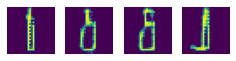


Epoch 35:
Discriminator
['disc_loss: 0.08931509405374527', 'disc_acc: 0.9860177636146545']
Generator
['gen_loss: 6.081947326660156', 'gen_acc: 0.013476562686264515']
Discriminator
['test_disc_loss: 4.297928333282471', 'test_disc_acc: 0.15886454284191132']
Generator
['test_gen_loss: 11.54366683959961', 'test_gen_acc: 0.0']


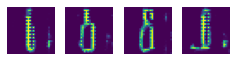


Epoch 36:
Discriminator
['disc_loss: 0.06484487652778625', 'disc_acc: 0.990217387676239']
Generator
['gen_loss: 6.6813859939575195', 'gen_acc: 0.009960937313735485']
Discriminator
['test_disc_loss: 6.311217784881592', 'test_disc_acc: 0.04581673443317413']
Generator
['test_gen_loss: 11.351921081542969', 'test_gen_acc: 0.0']


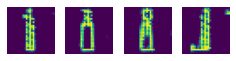


Epoch 37:
Discriminator
['disc_loss: 0.08330176770687103', 'disc_acc: 0.988043487071991']
Generator
['gen_loss: 6.454970359802246', 'gen_acc: 0.009570312686264515']
Discriminator
['test_disc_loss: 1.8476234674453735', 'test_disc_acc: 0.26792827248573303']
Generator
['test_gen_loss: 8.288917541503906', 'test_gen_acc: 0.0']


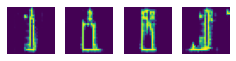


Epoch 38:
Discriminator
['disc_loss: 0.053645454347133636', 'disc_acc: 0.9912549257278442']
Generator
['gen_loss: 7.693605899810791', 'gen_acc: 0.01083984412252903']
Discriminator
['test_disc_loss: 2.049474000930786', 'test_disc_acc: 0.26792827248573303']
Generator
['test_gen_loss: 4.628453254699707', 'test_gen_acc: 0.0']


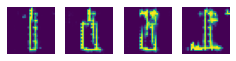


Epoch 39:
Discriminator
['disc_loss: 0.04939838871359825', 'disc_acc: 0.9918972253799438']
Generator
['gen_loss: 7.968184471130371', 'gen_acc: 0.0064453124068677425']
Discriminator
['test_disc_loss: 1.1029298305511475', 'test_disc_acc: 0.47310757637023926']
Generator
['test_gen_loss: 2.2253684997558594', 'test_gen_acc: 0.0']


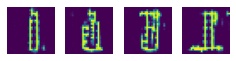


Epoch 40:
Discriminator
['disc_loss: 0.023043207824230194', 'disc_acc: 0.9972332119941711']
Generator
['gen_loss: 7.639097690582275', 'gen_acc: 0.0028320313431322575']
Discriminator
['test_disc_loss: 0.44188031554222107', 'test_disc_acc: 0.9536852836608887']
Generator
['test_gen_loss: 1.4404808282852173', 'test_gen_acc: 0.0']


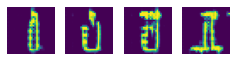


Epoch 41:
Discriminator
['disc_loss: 0.03307580202817917', 'disc_acc: 0.9954545497894287']
Generator
['gen_loss: 7.378426551818848', 'gen_acc: 0.0038085938431322575']
Discriminator
['test_disc_loss: 2.594621181488037', 'test_disc_acc: 0.1877489984035492']
Generator
['test_gen_loss: 6.201855659484863', 'test_gen_acc: 0.0']


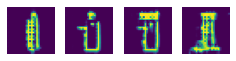


Epoch 42:
Discriminator
['disc_loss: 0.029758218675851822', 'disc_acc: 0.9962450861930847']
Generator
['gen_loss: 7.4107160568237305', 'gen_acc: 0.0030273436568677425']
Discriminator
['test_disc_loss: 0.9821557998657227', 'test_disc_acc: 0.4975099563598633']
Generator
['test_gen_loss: 5.555533409118652', 'test_gen_acc: 0.0']


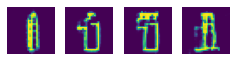


Epoch 43:
Discriminator
['disc_loss: 0.0262977983802557', 'disc_acc: 0.9973814487457275']
Generator
['gen_loss: 7.097371578216553', 'gen_acc: 0.0016601562965661287']
Discriminator
['test_disc_loss: 0.47958022356033325', 'test_disc_acc: 0.7763944268226624']
Generator
['test_gen_loss: 5.492343902587891', 'test_gen_acc: 0.0']


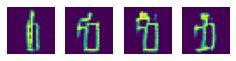


Epoch 44:
Discriminator
['disc_loss: 0.03172864764928818', 'disc_acc: 0.9960968494415283']
Generator
['gen_loss: 7.144920349121094', 'gen_acc: 0.0029296875']
Discriminator
['test_disc_loss: 3.068960666656494', 'test_disc_acc: 0.15537849068641663']
Generator
['test_gen_loss: 10.190535545349121', 'test_gen_acc: 0.0']


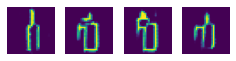


Epoch 45:
Discriminator
['disc_loss: 0.036480940878391266', 'disc_acc: 0.9947134256362915']
Generator
['gen_loss: 7.91542911529541', 'gen_acc: 0.0052734375931322575']
Discriminator
['test_disc_loss: 0.38195377588272095', 'test_disc_acc: 0.8356573581695557']
Generator
['test_gen_loss: 3.534400463104248', 'test_gen_acc: 0.0']


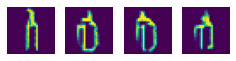


Epoch 46:
Discriminator
['disc_loss: 0.06737624853849411', 'disc_acc: 0.9890316128730774']
Generator
['gen_loss: 7.327353000640869', 'gen_acc: 0.009765625']
Discriminator
['test_disc_loss: 0.394079327583313', 'test_disc_acc: 0.8351593613624573']
Generator
['test_gen_loss: 3.860123872756958', 'test_gen_acc: 0.0']


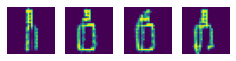


Epoch 47:
Discriminator
['disc_loss: 0.08852133899927139', 'disc_acc: 0.9851778745651245']
Generator
['gen_loss: 7.209549903869629', 'gen_acc: 0.012402343563735485']
Discriminator
['test_disc_loss: 0.257870614528656', 'test_disc_acc: 0.894920289516449']
Generator
['test_gen_loss: 5.20596981048584', 'test_gen_acc: 0.0']


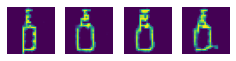


Epoch 48:
Discriminator
['disc_loss: 0.02748623862862587', 'disc_acc: 0.9963438510894775']
Generator
['gen_loss: 7.820096015930176', 'gen_acc: 0.0032226562034338713']
Discriminator
['test_disc_loss: 0.15301011502742767', 'test_disc_acc: 0.9492031931877136']
Generator
['test_gen_loss: 4.531473159790039', 'test_gen_acc: 0.0']


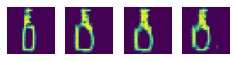


Epoch 49:
Discriminator
['disc_loss: 0.03171214833855629', 'disc_acc: 0.9952074885368347']
Generator
['gen_loss: 7.993015289306641', 'gen_acc: 0.004589843563735485']
Discriminator
['test_disc_loss: 0.07963769137859344', 'test_disc_acc: 0.9760956168174744']
Generator
['test_gen_loss: 5.359634876251221', 'test_gen_acc: 0.0']


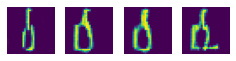

In [19]:
# train the GAN 
training(train_ds, test_ds, LOSS_FUNC, EPOCHS)

tf.Tensor([[0.9350072]], shape=(1, 1), dtype=float32)


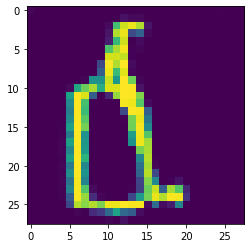

In [20]:
#test generator
image = generator(noise, training=False)

plt.imshow(image[0, :, :, 0])

#test discriminator 
result = discriminator(generated_image)
print(result)